# Time Series Forecasting

### About Dataset
#### Context
One challenge of modeling retail data is the need to make decisions based on limited history. Holidays and select major events come once a year, and so does the chance to see how strategic decisions impacted the bottom line. In addition, markdowns are known to affect sales – the challenge is to predict which departments will be affected and to what extent.

Content
You are provided with historical sales data for 45 stores located in different regions - each store contains a number of departments. The company also runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks.

Within the Excel Sheet, there are 3 Tabs – Stores, Features and Sales

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
pd.options.display.max_columns = 1000
import warnings
warnings.filterwarnings('ignore')
#import statsmodels.api as sm

from matplotlib import pyplot, dates
import datetime as dt
from math import sqrt
from matplotlib.pyplot import figure

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import performance_metrics

from prophet.plot import add_changepoints_to_plot
os.chdir("D:/Hien Nguyen/Extra Credit Ass")

In [2]:
feature = pd.read_csv('Features data set.csv', parse_dates = ['Date'], infer_datetime_format = True)
sales = pd.read_csv('sales data-set.csv', parse_dates = ['Date'], infer_datetime_format = True)
stores = pd.read_csv('stores data-set.csv')

###  <font color = 'blue'> Feature Dataset analysis

In [3]:
feature.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
feature.Store.nunique()

45

###  <font color = 'blue'> Sales data analysis

In [5]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [6]:
sales.groupby(['Store'])['Weekly_Sales'].mean()

Store
1     21710.543621
2     26898.070031
3      6373.033983
4     29161.210415
5      5053.415813
6     21913.243624
7      8358.766148
8     13133.014768
9      8772.890379
10    26332.303819
11    19276.762751
12    14867.308619
13    27355.136891
14    28784.851727
15     9002.493073
16     7863.224124
17    12954.393636
18    15733.313136
19    20362.126734
20    29508.301592
21    11283.435496
22    15181.218886
23    19776.180881
24    18969.106500
25    10308.157810
26    14554.129672
27    24826.984536
28    18714.889803
29     8158.810609
30     8764.237719
31    19681.907464
32    16351.621855
33     5728.414053
34    13522.081671
35    13803.596986
36     8584.412563
37    10297.355026
38     7492.478460
39    21000.763562
40    13763.632803
41    17976.004648
42    11443.370118
43    13415.114118
44     6038.929814
45    11662.897315
Name: Weekly_Sales, dtype: float64

### <font color = 'blue'> Store Analysis

In [7]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [8]:
stores.Type.value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

###  <font color = 'blue'> Merging all the 3 tables

In [9]:
df = pd.merge(sales, feature, on = ['Store', 'Date', 'IsHoliday'], how = 'left').merge(stores, on = ['Store'], how = 'left')

In [10]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-12-02,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-05-03,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [11]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

We can observe that only markdown columns have missing values hence we impute them with mean 

In [12]:
df.fillna(df.mean(), inplace = True)
# TO check if any NaN's are left
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

In [13]:
df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
dtype: object

In [14]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,4956.920816,4867.493911,5487.601593,3560.353127,3573.795304,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,7246.420196,3334.628621,115.390000,3383.168256,4628.975079,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [15]:
#temperature unit conversion
df['Temperature'] = (df['Temperature'] - 32) * 5./9.

#factorize (Yes/No to 1/0 conversion)
holidays_factor, types = df['IsHoliday'].factorize()
df['IsHoliday'] = holidays_factor
df.IsHoliday = df.IsHoliday.astype('str')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,0,5.727778,2.572,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.096358,8.106,A,151315
1,1,1,2010-12-02,46039.49,1,3.616667,2.548,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,0,4.405556,2.514,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,0,8.127778,2.561,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.319643,8.106,A,151315
4,1,1,2010-05-03,21827.90,0,8.055556,2.625,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,211.350143,8.106,A,151315


In [16]:
df['Month'] = pd.DatetimeIndex(df.Date).month
df['Year'] = pd.DatetimeIndex(df.Date).year
df['Month_Year'] = df.Date.dt.strftime('%Y-%m')
df['Day'] = df['Date'].dt.dayofyear
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Month', 'Year',
       'Month_Year', 'Day'],
      dtype='object')

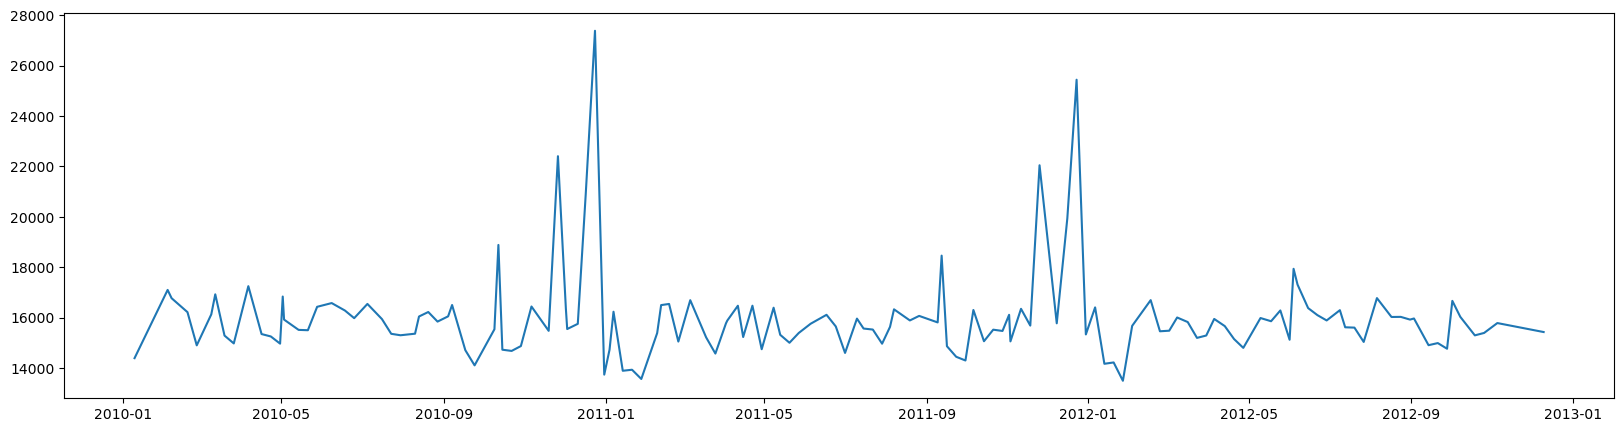

In [17]:
df_average_sales_week = df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].mean()
df_average_sales_sorted = df_average_sales_week.sort_values('Weekly_Sales', ascending = False)
plt.figure(figsize=(20,5))
plt.plot(df_average_sales_week.Date, df_average_sales_week.Weekly_Sales)
plt.show()

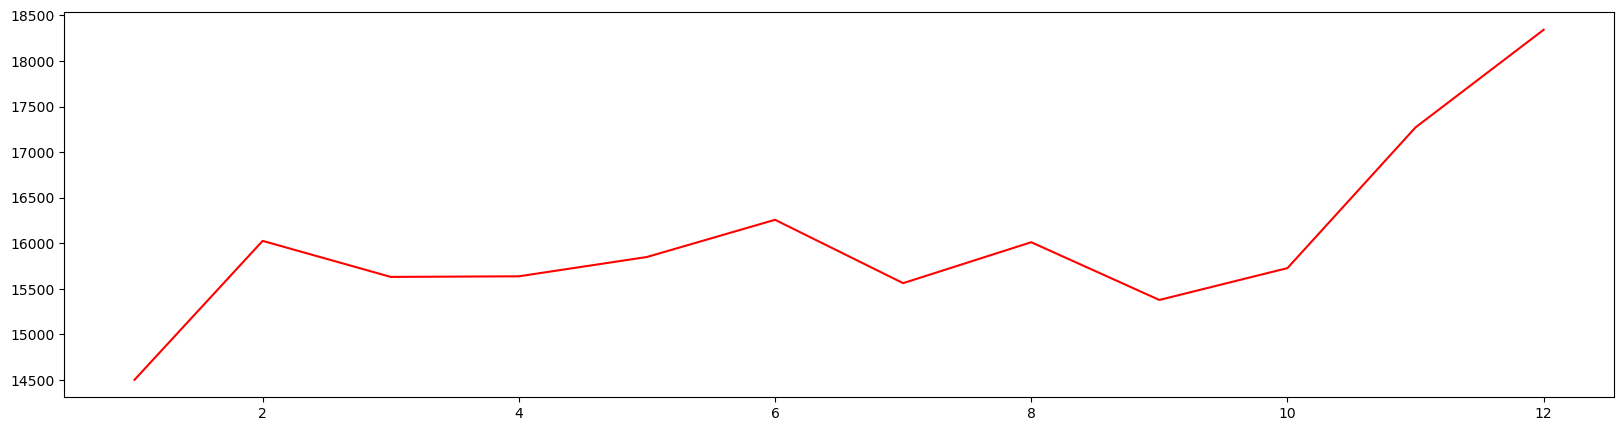

In [18]:
df_average_sales_monthly = df.groupby('Month', as_index=False).agg({'Weekly_Sales': 'mean'})
plt.figure(figsize=(20,5))
plt.plot(df_average_sales_monthly.Month, df_average_sales_monthly.Weekly_Sales, color = 'r')
plt.show()

#### <font color = 'blue'> Weekly sales per year

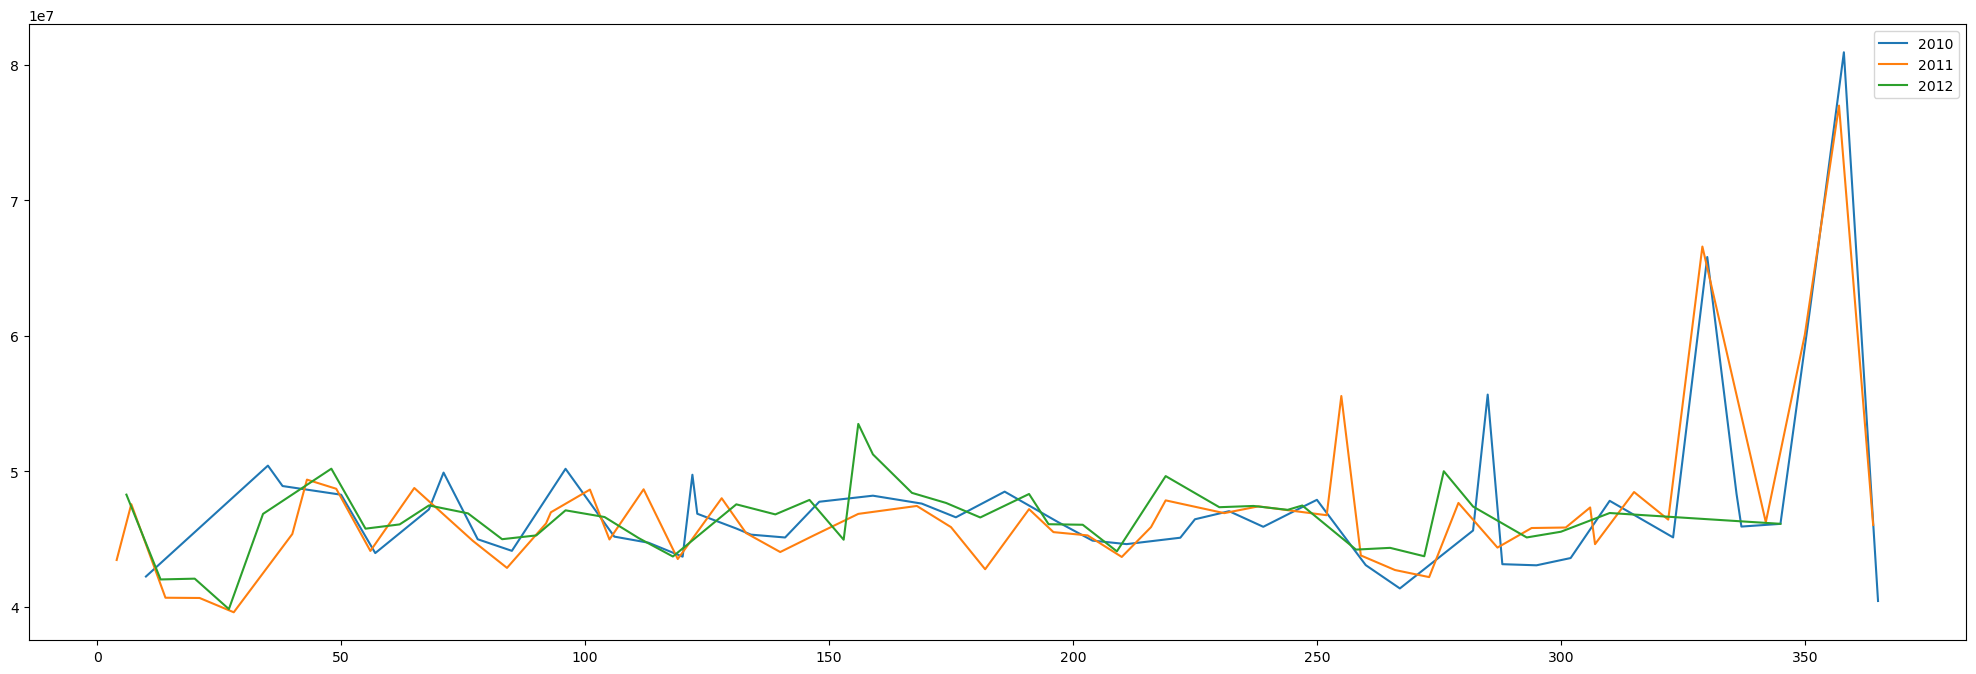

In [19]:
df10 = df.query('Year == 2010').groupby('Day', as_index=False).agg({'Weekly_Sales': 'sum'})
df11 = df.query('Year == 2011').groupby('Day', as_index=False).agg({'Weekly_Sales': 'sum'})
df12 = df.query('Year == 2012').groupby('Day', as_index=False).agg({'Weekly_Sales': 'sum'})
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(df10.Day, df10.Weekly_Sales, label = "2010")
ax.plot(df11.Day, df11.Weekly_Sales, label = "2011")
ax.plot(df12.Day, df12.Weekly_Sales, label = "2012")
ax.legend()
plt.show()

In [20]:
#df[df['IsHoliday']== '1']

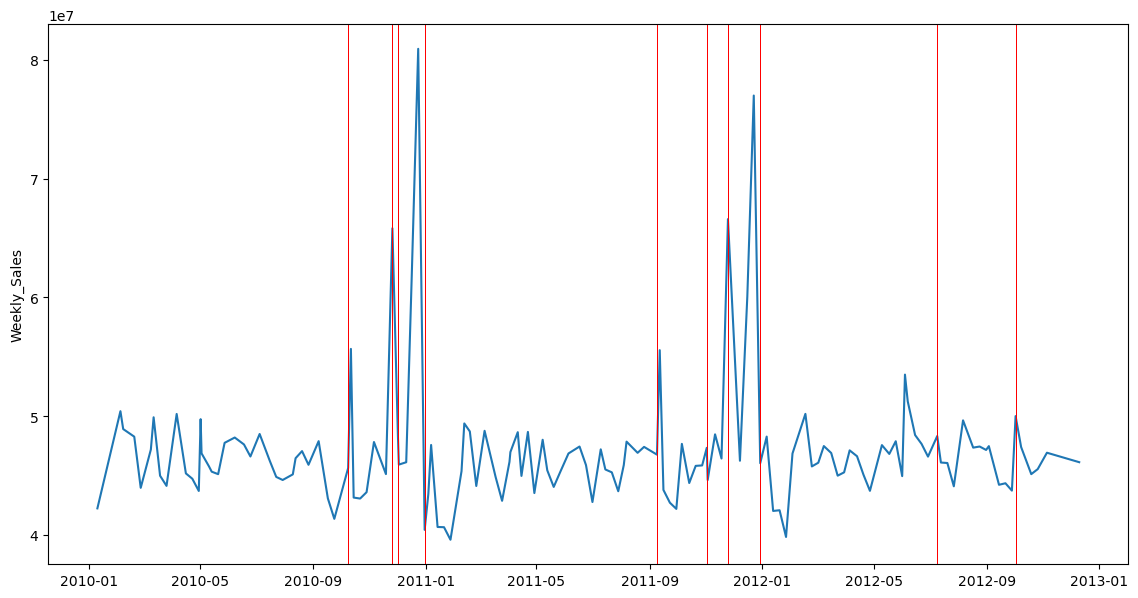

In [21]:
# holiday weeks are marked with red lines
df2=df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
f_1 = plt.figure(figsize=(12,6), dpi=100)
ax_1 = f_1.add_axes([0.0, 0.0, 0.9, 0.9])
ax_1.set_ylabel('Weekly_Sales')
ax_1.plot(df2['Date'], df2['Weekly_Sales'])

for x in df[df['IsHoliday']== '1']['Date']:
    ax_1.axvline(x=x, color='red', linewidth= 0.5)

## <font color = 'blue'> EDA: Plotting

array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'Dept'}>,
        <AxesSubplot:title={'center':'Date'}>,
        <AxesSubplot:title={'center':'Weekly_Sales'}>],
       [<AxesSubplot:title={'center':'Temperature'}>,
        <AxesSubplot:title={'center':'Fuel_Price'}>,
        <AxesSubplot:title={'center':'MarkDown1'}>,
        <AxesSubplot:title={'center':'MarkDown2'}>],
       [<AxesSubplot:title={'center':'MarkDown3'}>,
        <AxesSubplot:title={'center':'MarkDown4'}>,
        <AxesSubplot:title={'center':'MarkDown5'}>,
        <AxesSubplot:title={'center':'CPI'}>],
       [<AxesSubplot:title={'center':'Unemployment'}>,
        <AxesSubplot:title={'center':'Size'}>,
        <AxesSubplot:title={'center':'Month'}>,
        <AxesSubplot:title={'center':'Year'}>],
       [<AxesSubplot:title={'center':'Day'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

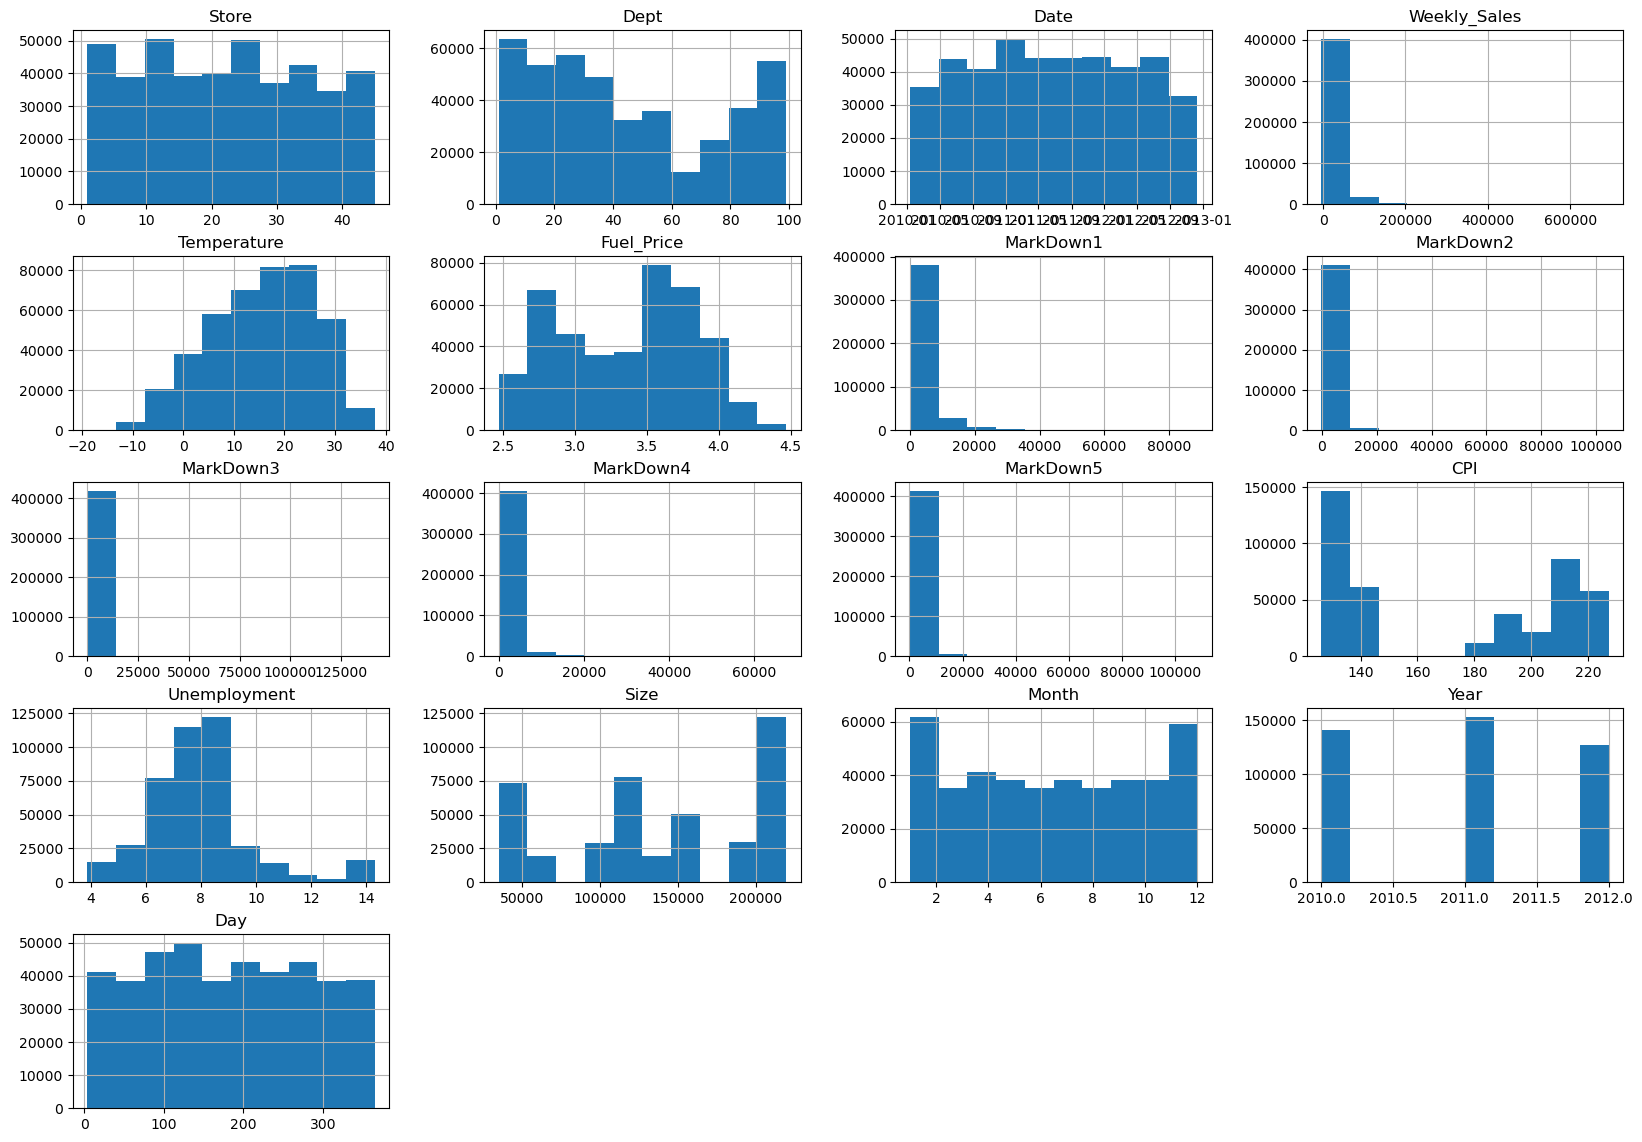

In [22]:
df.hist(figsize = (20 , 14))

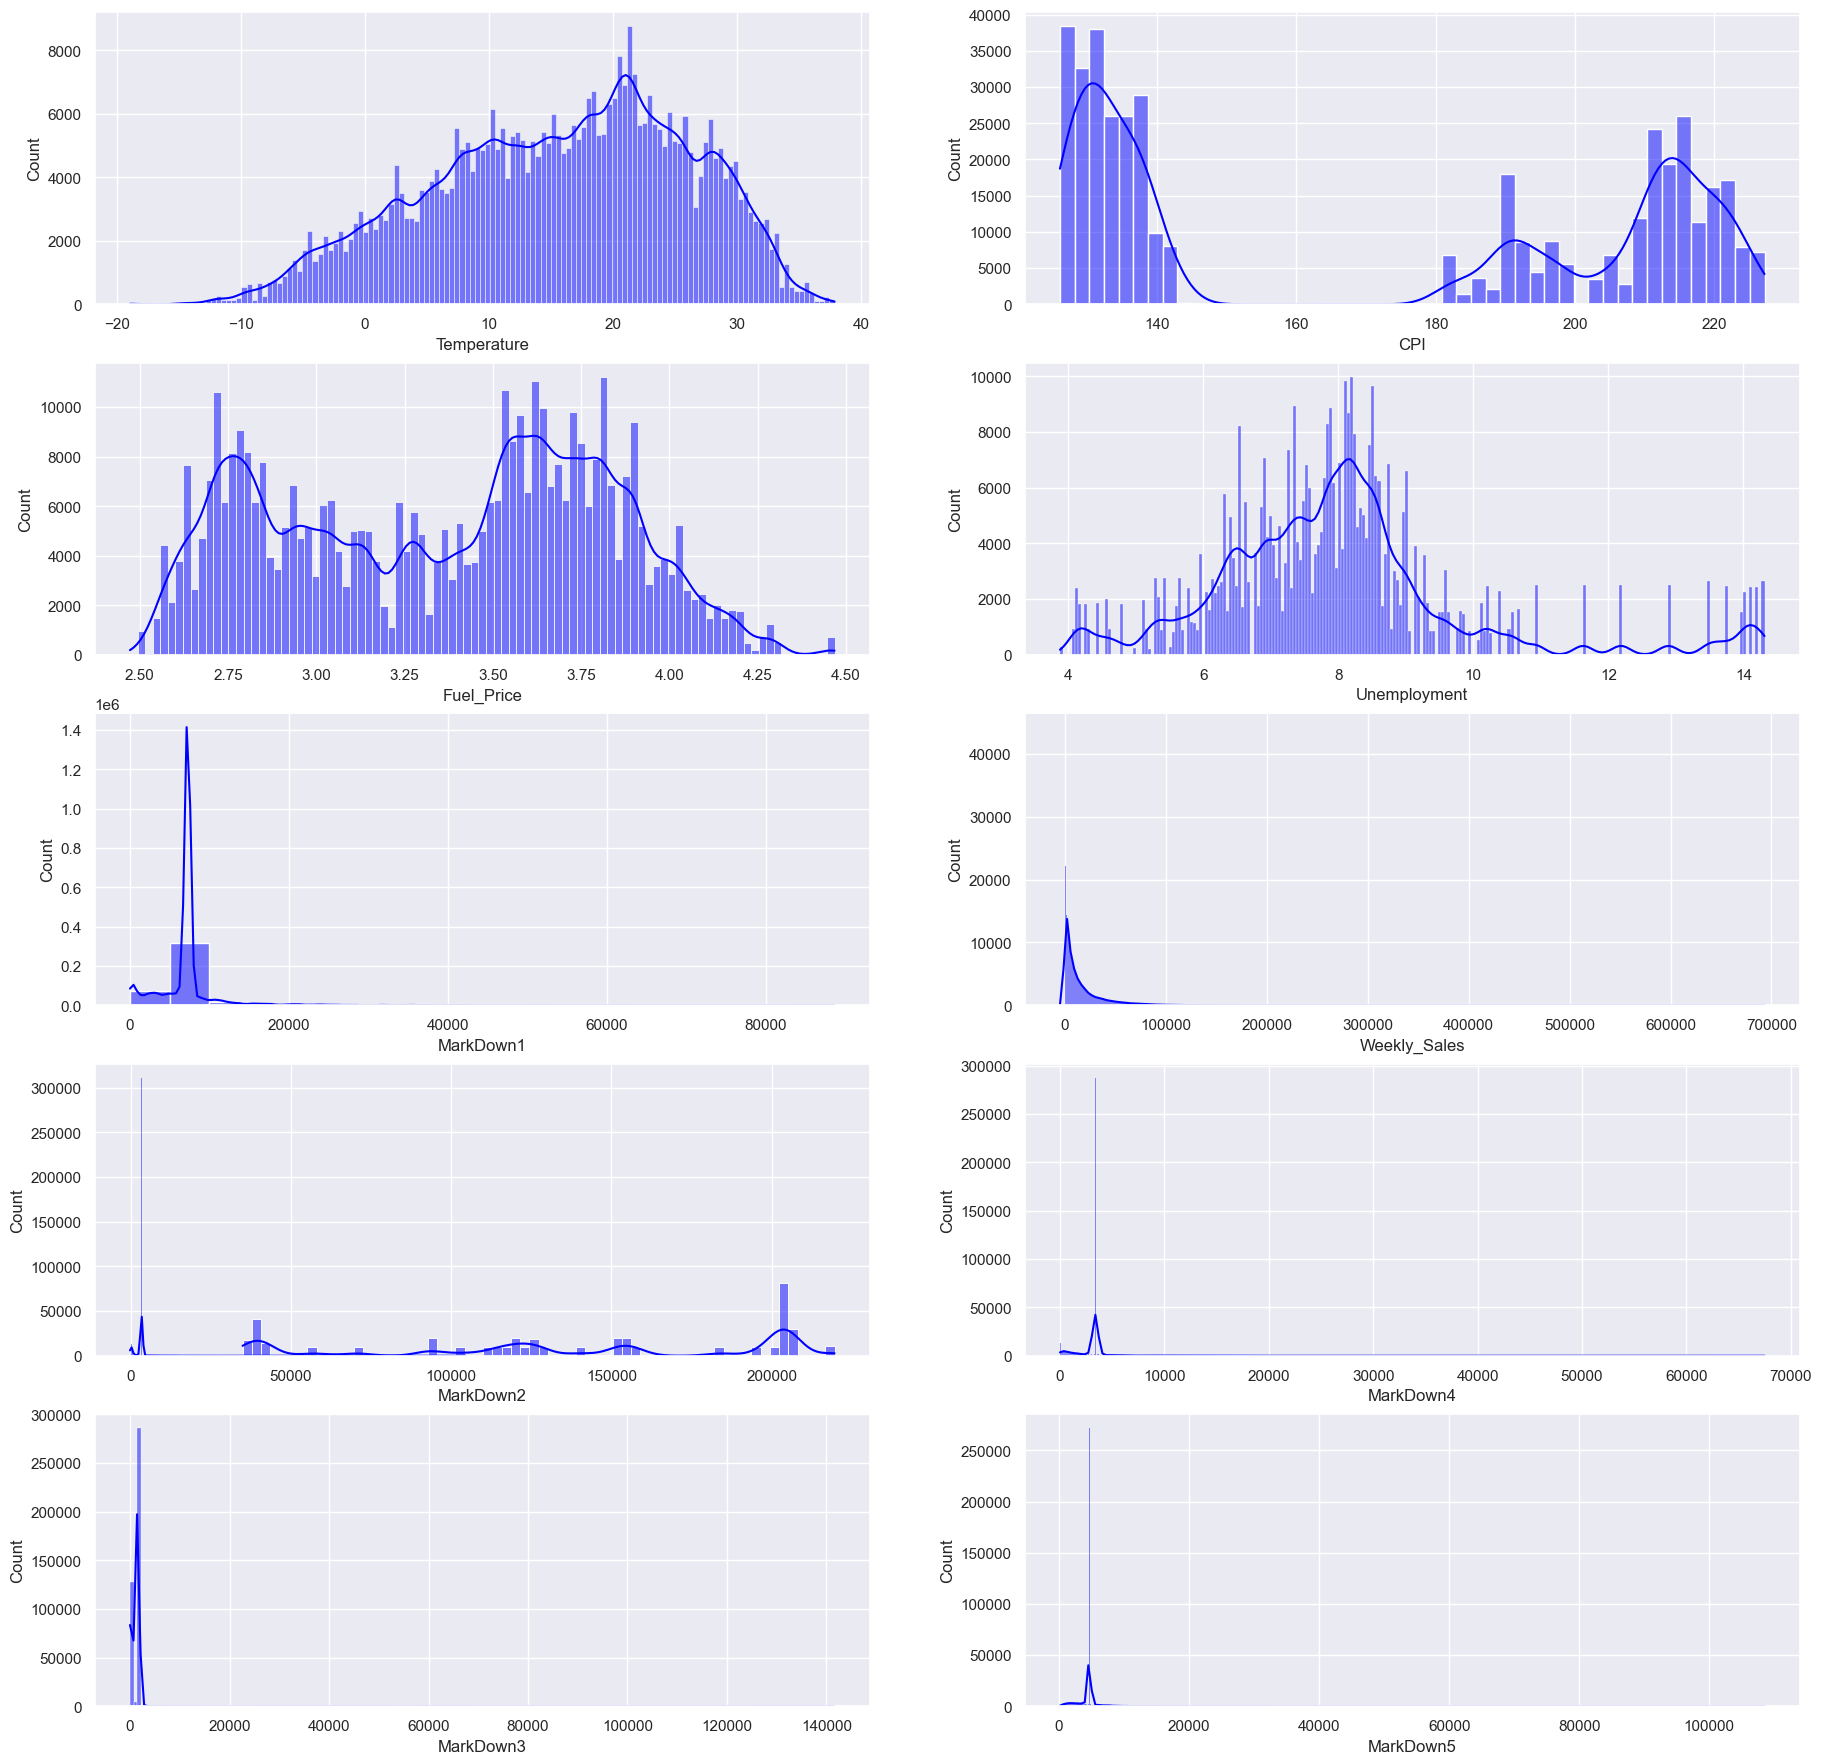

In [23]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(5, 2, figsize=(22, 22))

sns.histplot(data = df, x = 'Temperature', kde =True, color="blue", ax=axs[0, 0])
sns.histplot(data = df, x = 'Fuel_Price', kde =True, color="blue", ax=axs[1, 0])
sns.histplot(data = df, x = 'MarkDown1', bins =[0, 5000, 10000, 15000, 20000, 25000], kde=True, color="blue", ax=axs[2, 0])
sns.histplot(data = df, x = 'MarkDown2', bins =int(4000/5), kde=True, color="blue", ax=axs[3, 0])
sns.histplot(data = df, x = 'MarkDown3', bins = int(1000/5), kde=True, color="blue", ax=axs[4, 0])
sns.histplot(data = df, x = 'MarkDown4', bins =int(3500/5), kde=True, color="blue", ax=axs[3, 1])
sns.histplot(data = df, x = 'MarkDown5', bins =int(5000/5), kde=True, color="blue", ax=axs[4, 1])
sns.histplot(data = df, x = 'CPI', kde = True, color="blue", ax=axs[0, 1])
sns.histplot(data = df, x = 'Unemployment', kde=True, color="blue", ax=axs[1, 1])
sns.histplot(data = df, x = 'Weekly_Sales', kde=True, color="blue", ax=axs[2, 1])
sns.histplot(data = df, x = 'Size', kde=True, color="blue", ax=axs[3, 0])

plt.show()
#fig.savefig('histogram.png', dpi=fig.dpi)

Using log transform on most variables

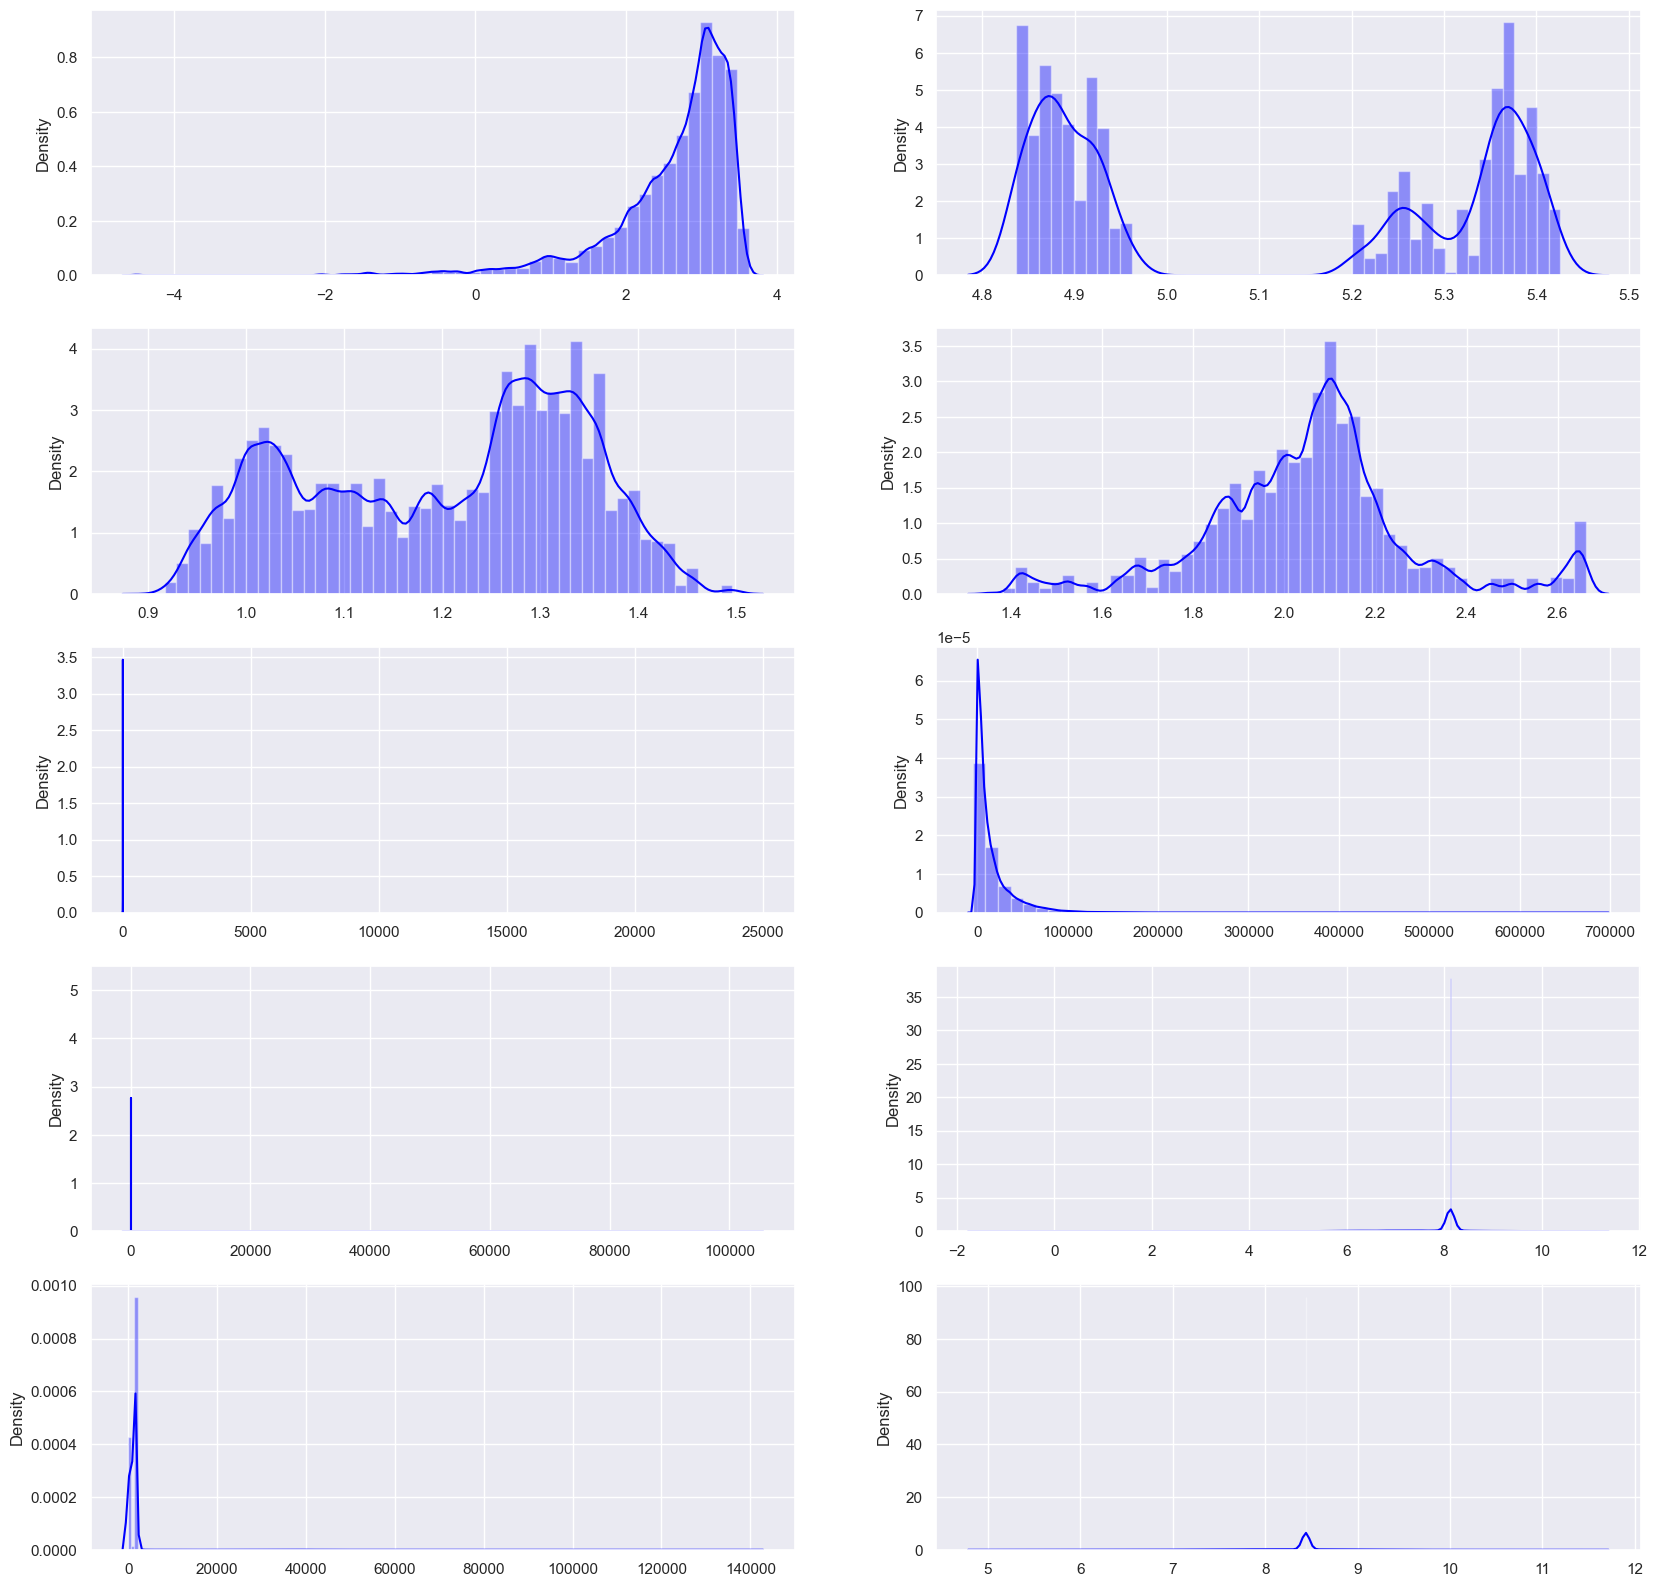

In [24]:
sns.set(style="darkgrid")
fig1, axs = plt.subplots(5, 2, figsize=(20, 20))

sns.distplot(np.log(df.Temperature.values), hist = True, kde=True, color="blue", ax=axs[0, 0])
sns.distplot(np.log(df.Fuel_Price.values), hist = True, kde=True, color="blue", ax=axs[1, 0])
sns.distplot(np.log(df.MarkDown1.values), hist=True, bins =[0, 5000, 10000, 15000, 20000, 25000], kde=True, color="blue", ax=axs[2, 0])
sns.distplot(df.MarkDown2.values, hist=True, bins=int(4000/5), kde=True, color="blue", ax=axs[3, 0])
sns.distplot(df.MarkDown3.values, hist=True, bins = int(1000/5), kde=True, color="blue", ax=axs[4, 0])
sns.distplot(np.log(df.MarkDown4.values), hist = True, bins =int(3500/5), kde=True, color="blue", ax=axs[3, 1])
sns.distplot(np.log(df.MarkDown5.values), hist=True, bins =int(5000/5), kde=True, color="blue", ax=axs[4, 1])
sns.distplot(np.log(df.CPI.values), hist=True, kde=True, color="blue", ax=axs[0, 1])
sns.distplot(np.log(df.Unemployment.values), hist=True, kde=True, color="blue", ax=axs[1, 1])
sns.distplot(df.Weekly_Sales.values, hist=True, kde=True, color="blue", ax=axs[2, 1])
sns.distplot(np.log(df.Size.values), hist=True, kde=True, color="blue", ax=axs[3, 0])

plt.show()
#fig1.savefig('histogram_log.png', dpi=fig1.dpi)

Since log transformations have no effect on models hence let's explore more

Let's check CPI v/s weekly sales

In [25]:
df['cpi_bins'] = pd.cut(df.CPI, bins = [120, 150, 180, 210, 230], labels = ['120 - 150','151 - 180','181 - 210','211 - 230'], include_lowest = True)

In [26]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Month', 'Year',
       'Month_Year', 'Day', 'cpi_bins'],
      dtype='object')

In [27]:
df.CPI.max()

227.2328068

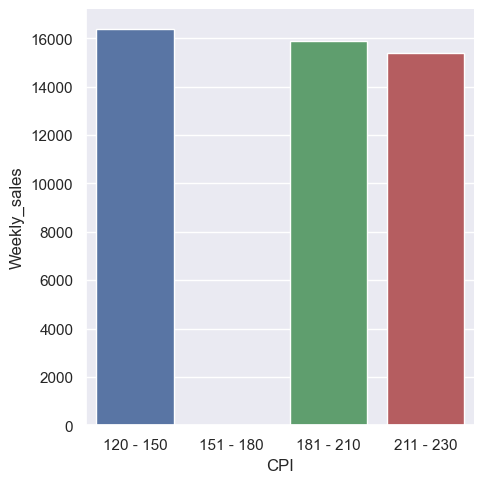

In [28]:
fig = sns.catplot(x ='cpi_bins', y = 'Weekly_Sales', data = df, kind='bar', ci=None)
fig.set_axis_labels("CPI", "Weekly_sales")

In [29]:
#df["Date_string"] = pd.to_numeric(df["Date"].astype(str).str.replace("-", ""))

In [30]:
#def fake_dates(x, pos):
#     """ Custom formater to turn floats into e.g., 2016-05-08"""
    #return dates.num2date(x).strftime('%Y-%m')

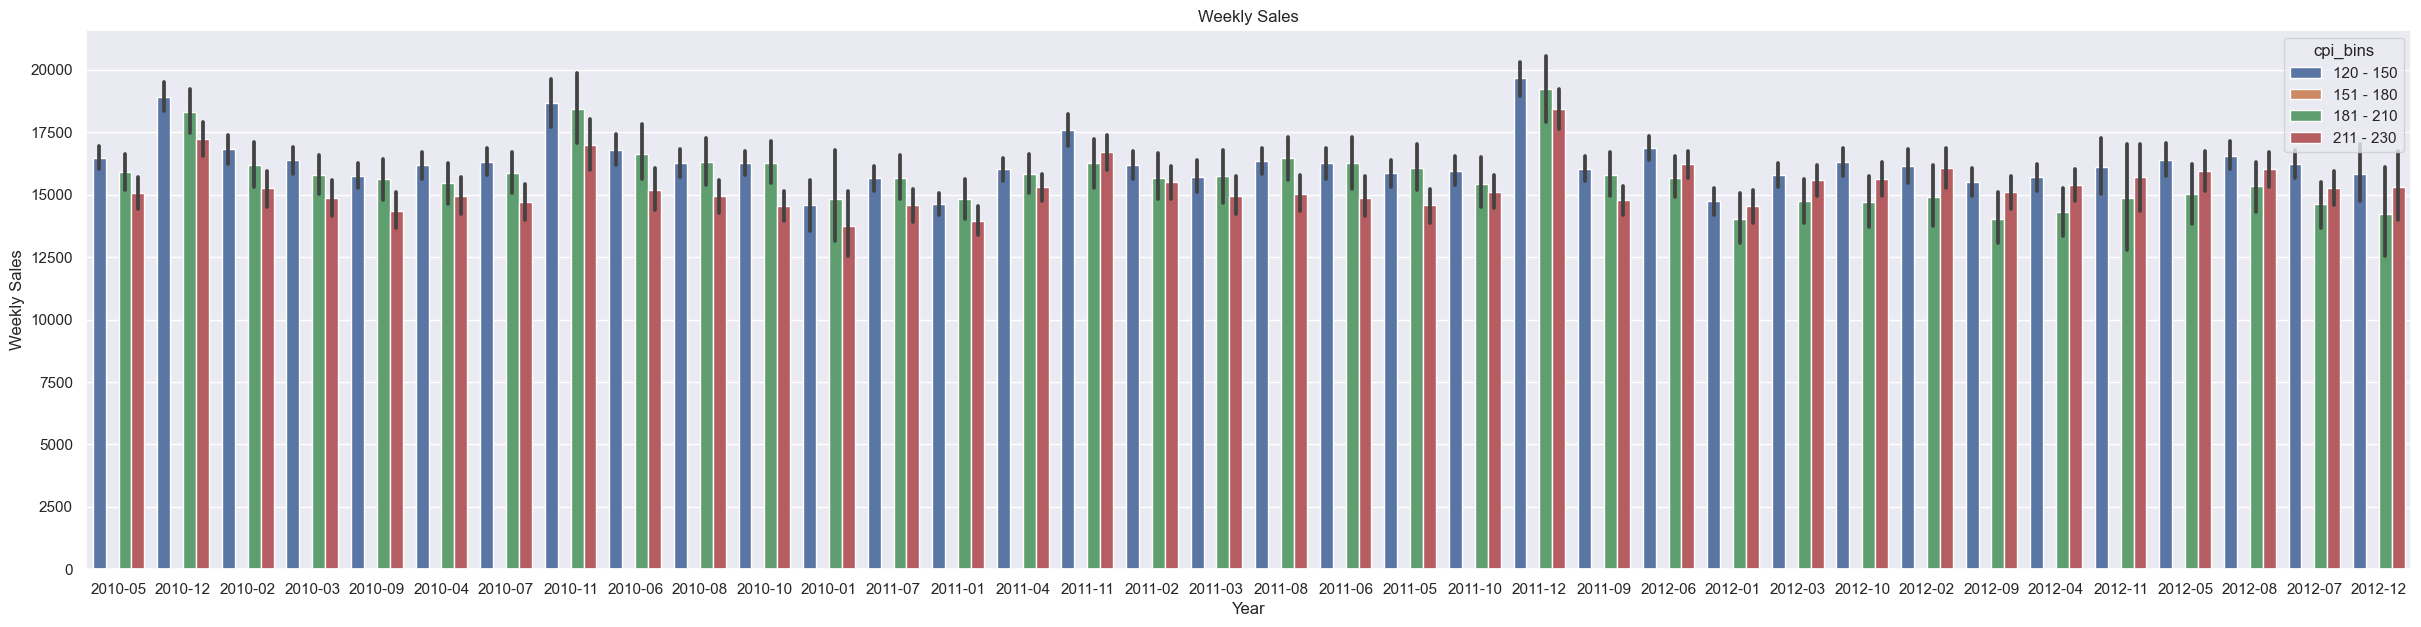

In [31]:
plt.figure(figsize = (30, 7))
ax = sns.barplot(x="Month_Year", y ="Weekly_Sales", hue = "cpi_bins", data=df)
ax.set(xlabel="Year", ylabel = "Weekly Sales", title="Weekly Sales")
vals = ax.get_yticks()

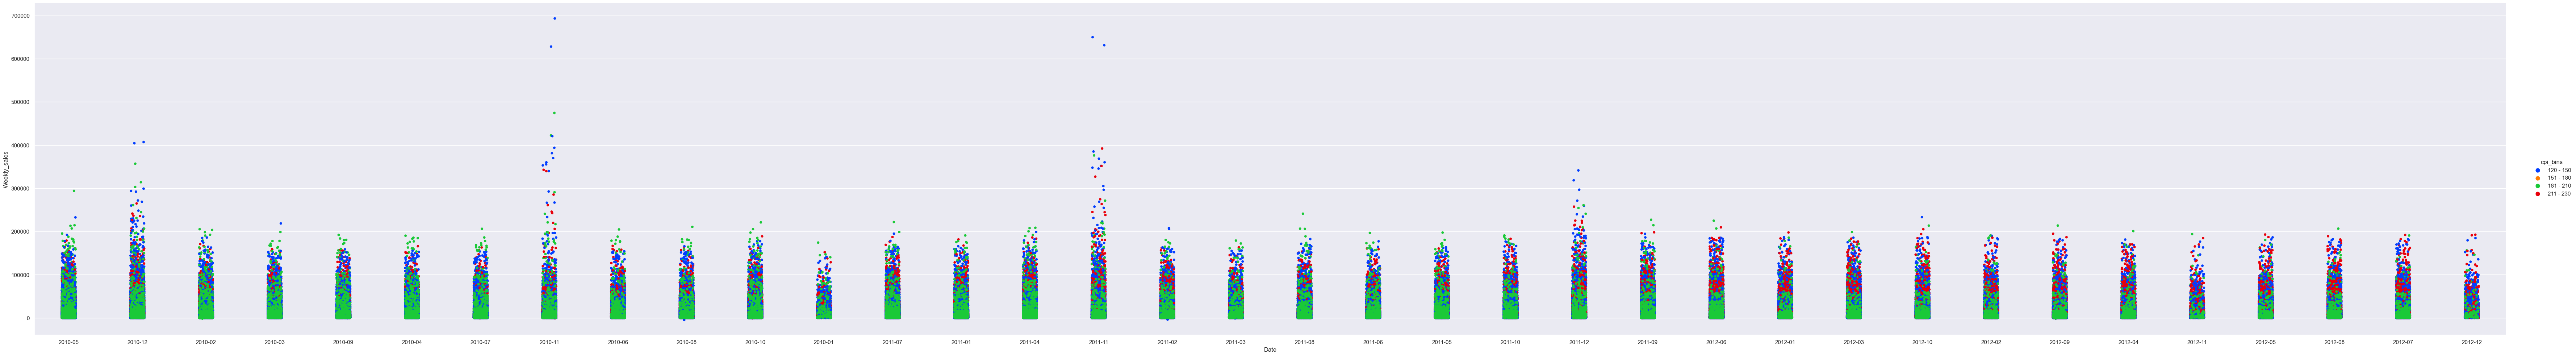

In [32]:
fig = sns.catplot(x ='Month_Year', y = 'Weekly_Sales', hue = 'cpi_bins', data = df, ci=None, palette = 'bright', height=10, aspect=7)
fig.set_axis_labels("Date", "Weekly_sales")

In [33]:
df.Unemployment.max()

14.313

In [34]:
df['umemployment_bins'] = pd.cut(df.CPI, bins = [3, 6, 9, 12, 15], labels = ['3 - 6','6 - 9','9 - 12','12 - 15'], include_lowest = True)

In [35]:
# fig = sns.catplot(x ='Month_Year', y = 'Weekly_Sales', hue = 'umemployment_bins', data = df, ci=None, palette = 'bright', height=10, aspect=7)
# fig.set_axis_labels("Date", "Weekly_sales")

In [36]:
#sns.lmplot(x='Date_string', y='Unemployment', hue='cpi_bins', data=df, fit_reg = True)

In [37]:
# plt.figure(figsize = (12,5))
# ax = sns.barplot(x="Date", y ="Weekly_Sales", hue = "umemployment_bins", data=df)
# ax.set(xlabel="category", ylabel = "Date", title="Weekly Sales")
# vals = ax.get_yticks()

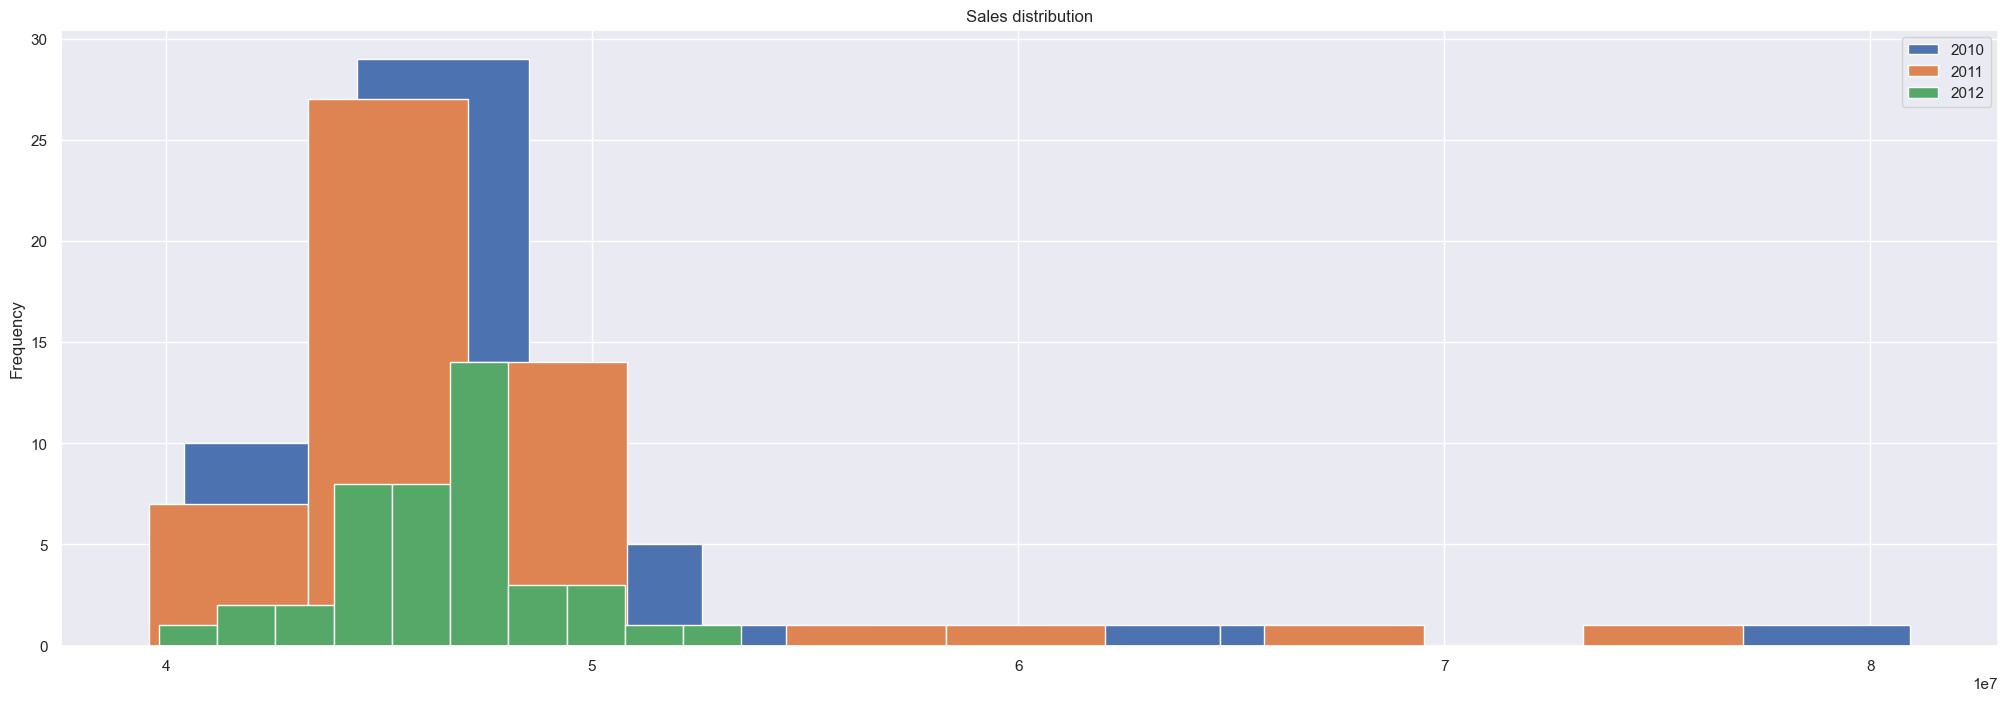

In [38]:
# Sales sums distribution

fig, ax = plt.subplots(figsize=(25,8))

df10['Weekly_Sales'].plot(kind='hist', title='Sales distribution', label = "2010");

df11['Weekly_Sales'].plot(kind='hist', label = "2011");
df12['Weekly_Sales'].plot(kind='hist', label = "2012");

ax.legend()
plt.show()

### <font color = 'blue'> Checking for seasonality

In [39]:
df_average_sales_week['Date'].tail(5)

138   2012-10-08
139   2012-10-19
140   2012-10-26
141   2012-11-05
142   2012-12-10
Name: Date, dtype: datetime64[ns]

In [40]:
df_average_sales_week['rol_month'] = df_average_sales_week['Weekly_Sales'].rolling(4).mean()

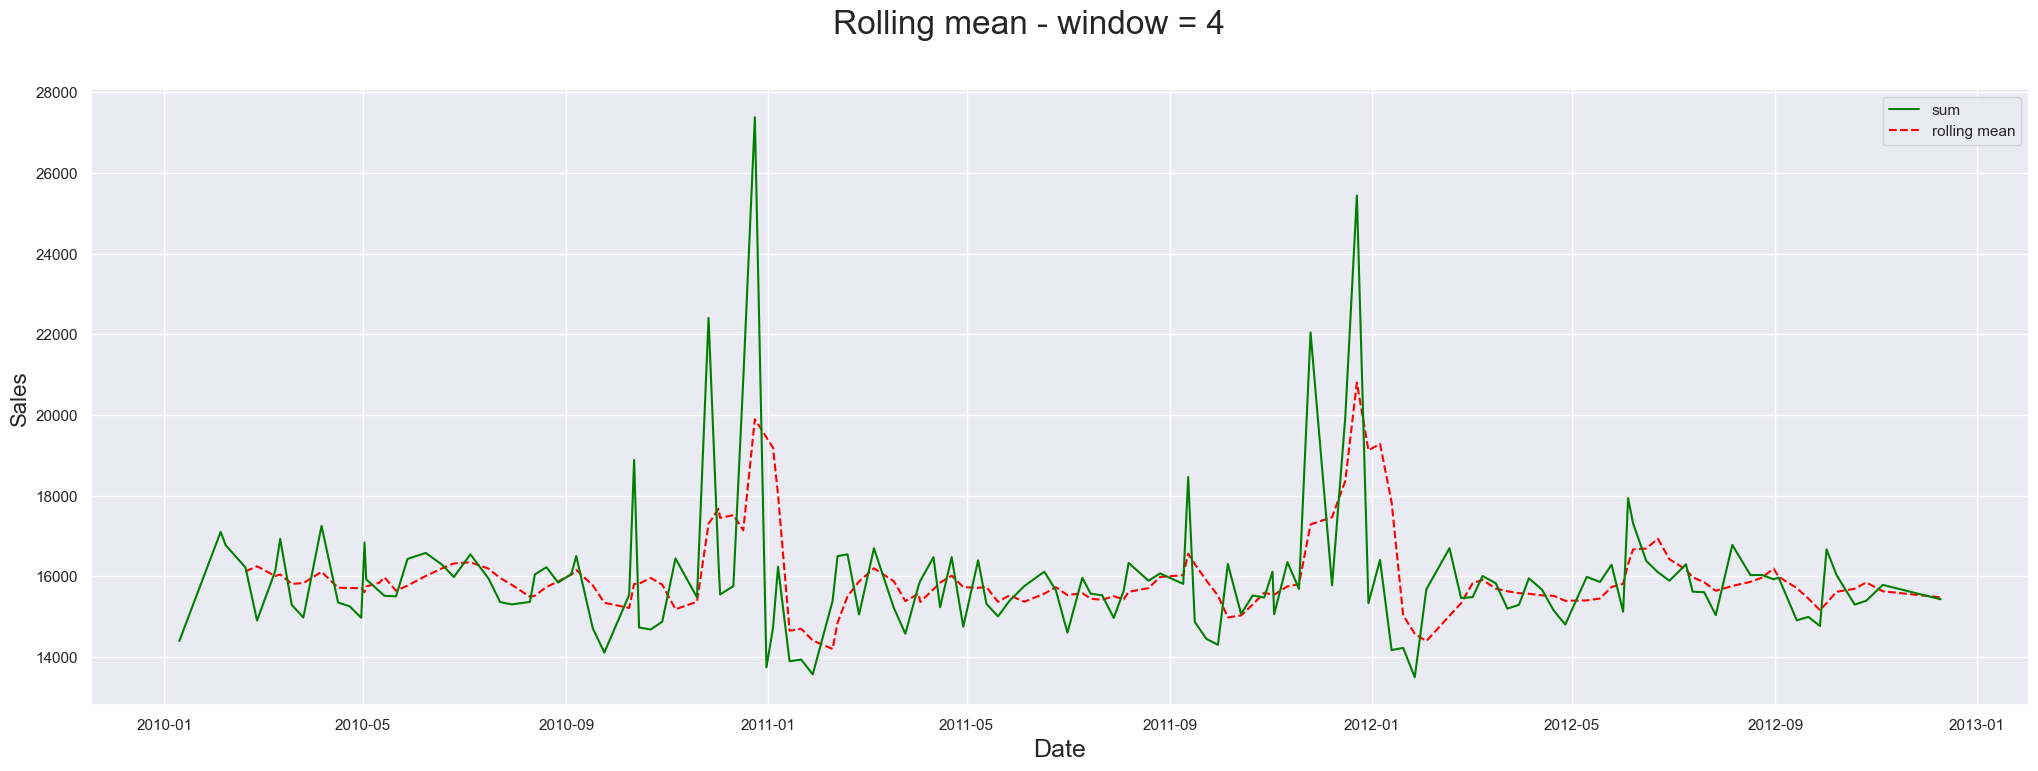

In [41]:
fig = plt.figure(figsize=(25,8))
line1, = plt.plot(df_average_sales_week.Date, df_average_sales_week.rol_month, '--', color='red')
line2, = plt.plot(df_average_sales_week.Date, df_average_sales_week.Weekly_Sales,  color='green')

fig.suptitle('Rolling mean - window = 4', fontsize=24)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Sales', fontsize=16)

plt.legend((line2, line1), ['sum', 'rolling mean'])

plt.show()

### <font color = 'blue'> Difference of Weekly Sales sum by day of year compared with a previous day of year

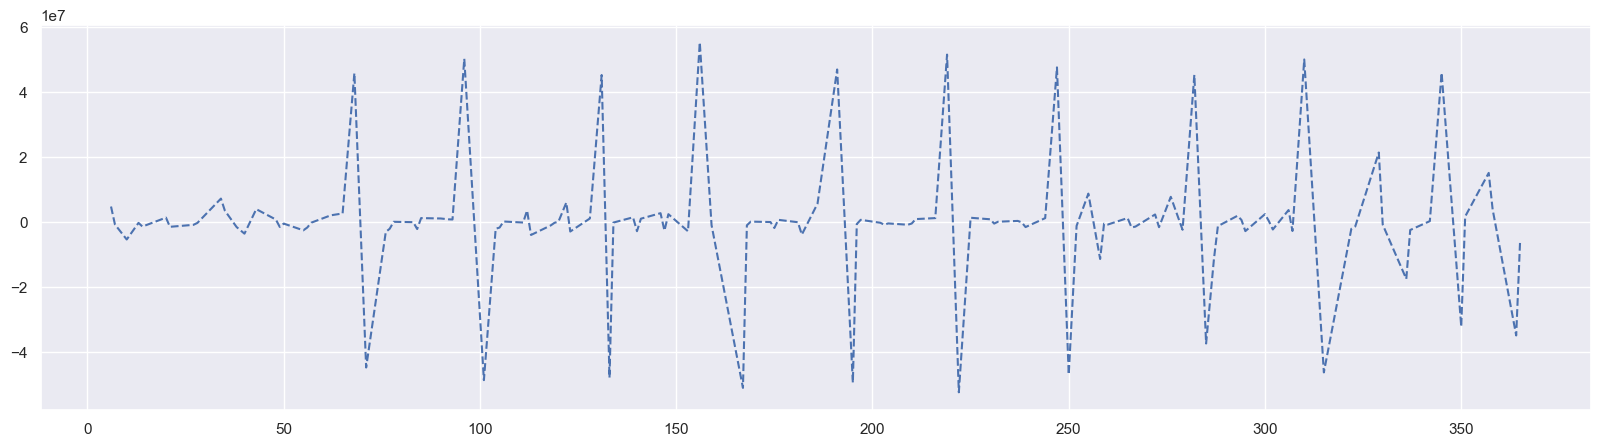

In [42]:
df_diff = df.groupby('Day', as_index=False).agg({'Weekly_Sales': 'sum'})

df_diff['differ'] = df_diff['Weekly_Sales'].diff()
plt.figure(figsize=(20,5))
plt.plot(df_diff.Day, df_diff.differ, '--', color = 'b')
plt.show()

### <font color = 'blue'> Analyzing Consumer Price Index

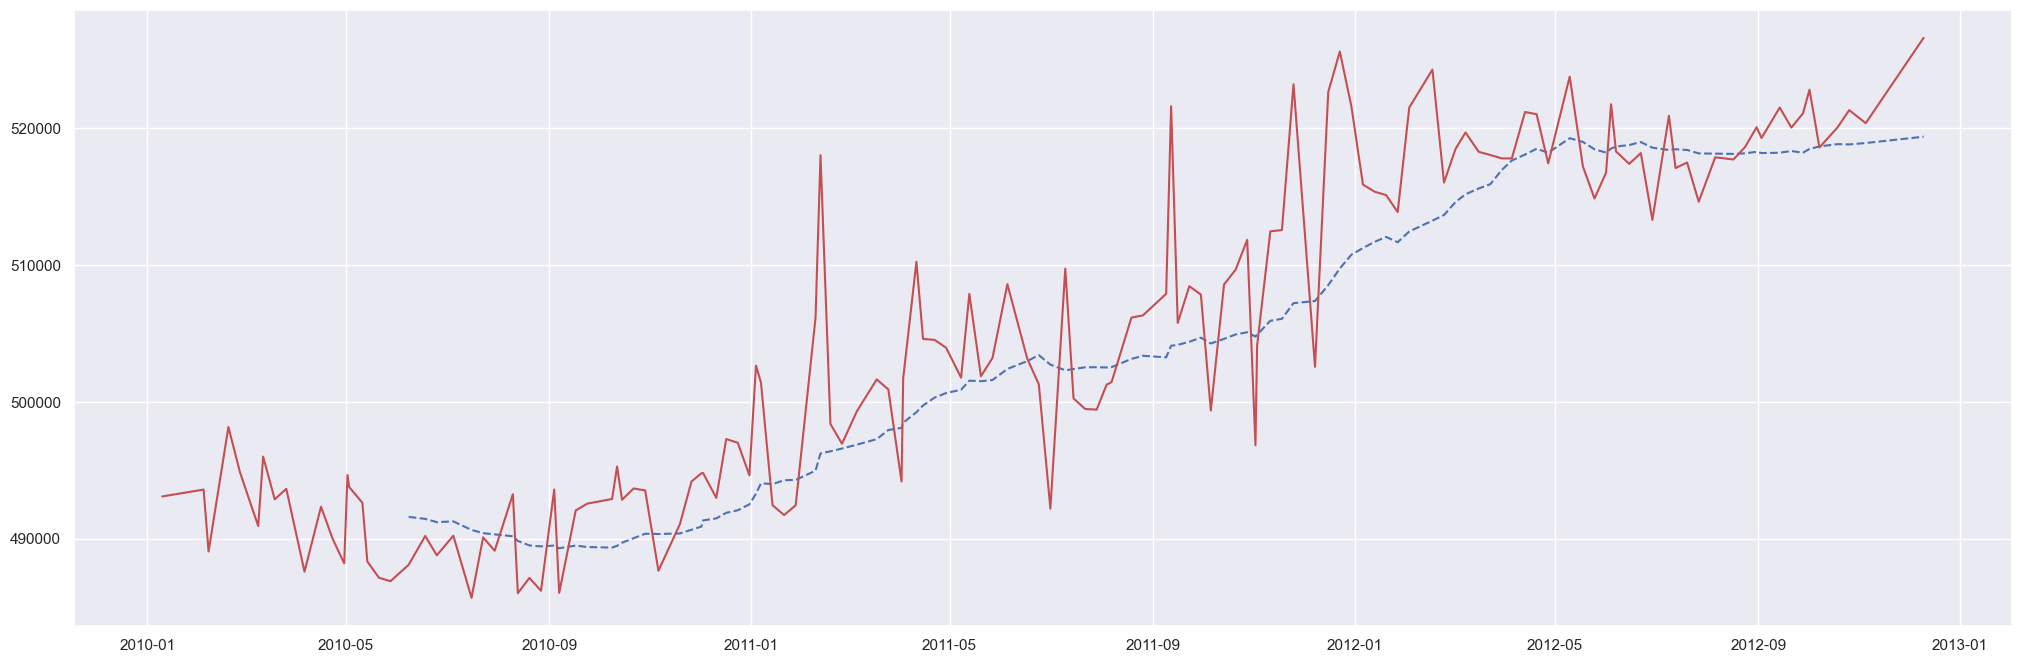

In [43]:
fig = plt.figure(figsize=(25,8))
df_average_sales_week2 = df.groupby('Date', as_index=False).agg({'CPI': 'sum'})
df_average_sales_sorted = df_average_sales_week2.sort_values('CPI', ascending = False)

df_average_sales_week2['rol_month'] = df_average_sales_week2['CPI'].rolling(20).mean()
line1 = plt.plot(df_average_sales_week2.Date, df_average_sales_week2.rol_month, '--', color='b')


plt.plot(df_average_sales_week2.Date, df_average_sales_week2.CPI, color = 'r')
plt.show()

The above diagram shows the analysis of CPI over the tenure provided. We can observe that not only payment capability has increased over the years but also that there are visible spikes during festive seasons.

## <font color = 'blue'> Forecasting

### One Hot Encoding

In [44]:
# data_onehot = df[['Type']]
# enc = OneHotEncoder(sparse = False)
# enc.fit(data_onehot)
# data_onehot_transformed = enc.transform(data_onehot)
# cols = ['Type_A', 'Type_B', 'Type_C']
# data = pd.DataFrame(data_onehot_transformed, columns = cols)
# df = pd.concat([df, data], axis = 1)
# df.drop(['Type'], axis = 1, inplace = True)

### <font color = 'blue'> Model - FbProphet

In [45]:
model = Prophet()

### <font color = 'blue'> Sales forecast over next 3 years

In [46]:
df_sales=df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()

df_sales = df_sales.rename(columns = {'Date':'ds', 'Weekly_Sales':'y'})

In [47]:
model.fit(df_sales)

23:49:24 - cmdstanpy - INFO - Chain [1] start processing
23:49:24 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
df_sales.tail()

,ds,y
138,2012-10-08,47403451.04
139,2012-10-19,45122410.57
140,2012-10-26,45544116.29
141,2012-11-05,46925878.99
142,2012-12-10,46128514.25


          ds          yhat    yhat_lower    yhat_upper
0 2012-12-16  6.147378e+07  5.672591e+07  6.676661e+07
1 2012-12-23  6.372843e+07  5.866667e+07  6.891020e+07
2 2012-12-30  5.847849e+07  5.303158e+07  6.362071e+07
3 2013-01-06  4.832940e+07  4.316019e+07  5.340989e+07
4 2013-01-13  4.052000e+07  3.517495e+07  4.586576e+07


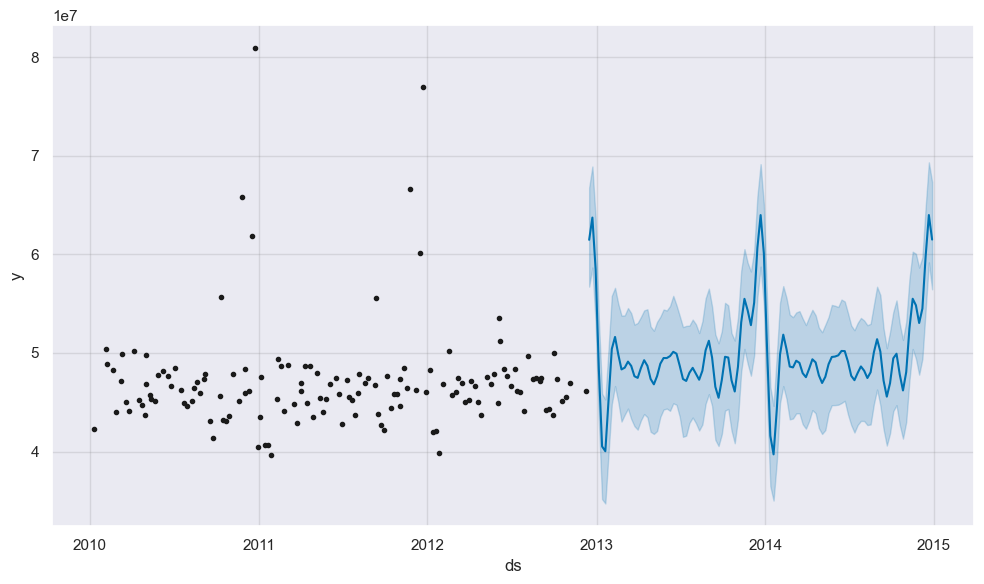

In [49]:
#Range of weeks for forecast
future_dates = pd.date_range("20121216","20141230", freq='W')
future_dates = [pd.to_datetime(i) for i in future_dates]
future = pd.DataFrame([dt.datetime.strftime(i, '%Y-%m-%d') for i in future_dates],  columns=['ds'])
forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

### <font color = 'blue'> Predicting for next 3 months of 2012

In [50]:
dates = pd.date_range("20111126","20121110", freq='W')
dates = [pd.to_datetime(i) for i in dates]
dates_for_forecast = pd.DataFrame([dt.datetime.strftime(i, '%Y-%m-%d') for i in dates],  columns=['ds'])

          ds          yhat    yhat_lower    yhat_upper
0 2012-12-16  6.147378e+07  5.672591e+07  6.676661e+07
1 2012-12-23  6.372843e+07  5.866667e+07  6.891020e+07
2 2012-12-30  5.847849e+07  5.303158e+07  6.362071e+07
3 2013-01-06  4.832940e+07  4.316019e+07  5.340989e+07
4 2013-01-13  4.052000e+07  3.517495e+07  4.586576e+07


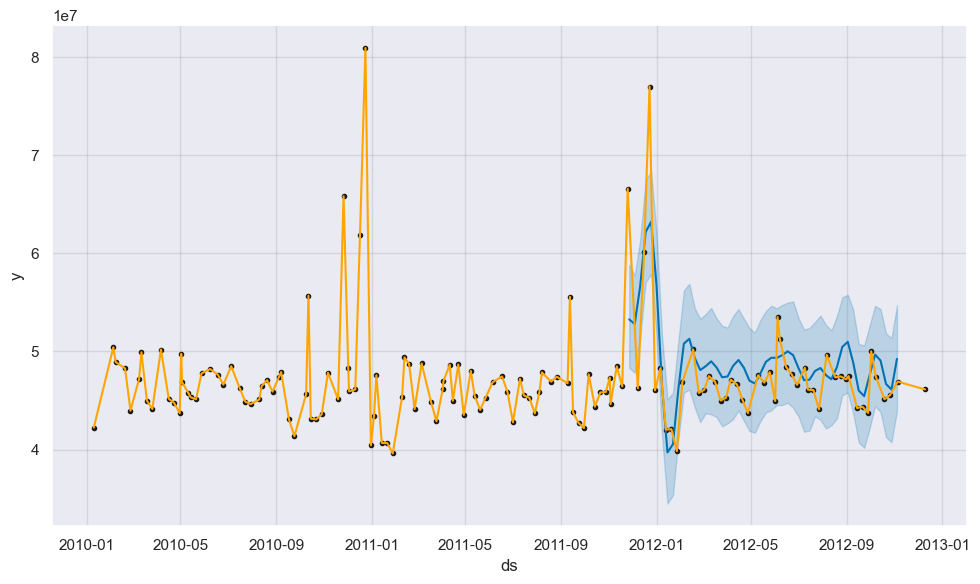

In [51]:
forecast_dates = model.predict(dates_for_forecast)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast_dates)

plt.plot(df_sales.ds, df_sales.y, color = 'orange')

plt.show()